<a href="https://colab.research.google.com/github/danieltoha197/DBSCAN_TA_DANIEL/blob/main/Percobaan_DBSCAN_PCA_semua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Berjalan di lingkungan Colab. Gunakan files.upload() untuk mengunggah file.
Silakan unggah file Excel 'Dataset_Bersih_Normalized_with_PCA_per_Source (1).xlsx'.
PENTING: Pastikan nama file yang Anda unggah persis atau mengandung 'Dataset_Bersih_Normalized_with_PCA_per_Source' (case-insensitive) dan berekstensi .xls atau .xlsx.


Saving Dataset_Bersih_Normalized_with_PCA_per_Source (1).xlsx to Dataset_Bersih_Normalized_with_PCA_per_Source (1).xlsx

--- Mulai proses DBSCAN dan Anomaly Detection untuk file Dataset_Bersih_Normalized_with_PCA_per_Source ---
Memproses file: Dataset_Bersih_Normalized_with_PCA_per_Source (1).xlsx
DataFrame Dataset_Bersih_Normalized_with_PCA_per_Source (beberapa baris pertama):
                     History  Timestamp     X      Y     Z           Source  \
0  [2025-04-27 18:22:20.090]         211 -4.59  -8.71  0.75  Suprax(Normal)   
1  [2025-04-27 18:22:20.144]         338  0.78  -8.79  0.82  Suprax(Normal)   
2  [2025-04-27 18:22:20.251]         441  0.51 -11.65  1.69  Suprax(Normal)   
3  [2025-04-27 18:22:20.356]         544  0.67 -10.98  1.57  Suprax(Normal)   
4  [2025-04-27 18:22:20.463]         647  1.69 -10.67  1.61  Suprax(Normal)   

   X _normalized  Y _normalized  Z _normalized  PC1_Source  PC2_Source  
0       0.088240       0.080747       0.494605   -0.002674    0.016784 

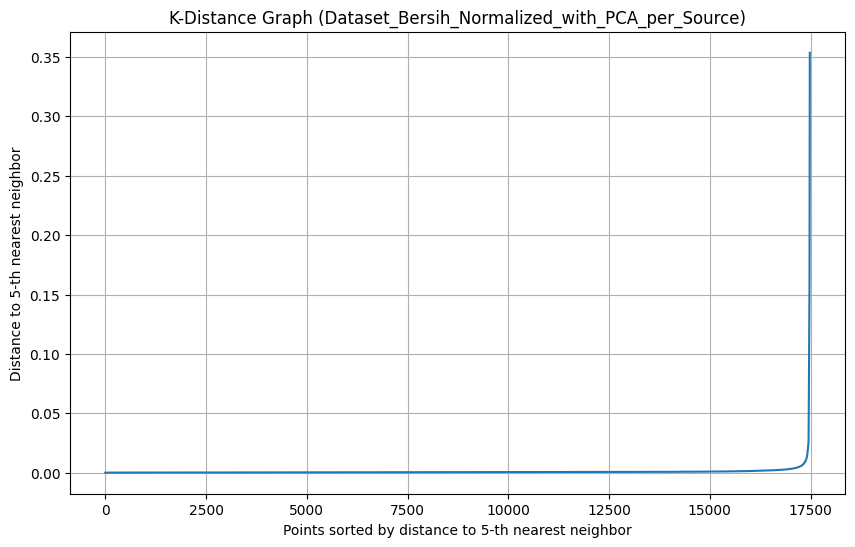

Lihat grafik K-Distance di atas untuk membantu memilih nilai 'eps'.
Gunakan nilai 'min_samples' = 5 untuk DBSCAN.

Menerapkan algoritma DBSCAN pada data PCA (Dataset_Bersih_Normalized_with_PCA_per_Source)...
Menggunakan eps=0.03 dan min_samples=5 untuk DBSCAN.

DataFrame Dataset_Bersih_Normalized_with_PCA_per_Source setelah penambahan label cluster DBSCAN (beberapa baris pertama):
                     History  Timestamp     X      Y     Z           Source  \
0  [2025-04-27 18:22:20.090]         211 -4.59  -8.71  0.75  Suprax(Normal)   
1  [2025-04-27 18:22:20.144]         338  0.78  -8.79  0.82  Suprax(Normal)   
2  [2025-04-27 18:22:20.251]         441  0.51 -11.65  1.69  Suprax(Normal)   
3  [2025-04-27 18:22:20.356]         544  0.67 -10.98  1.57  Suprax(Normal)   
4  [2025-04-27 18:22:20.463]         647  1.69 -10.67  1.61  Suprax(Normal)   

   X _normalized  Y _normalized  Z _normalized  PC1_Source  PC2_Source  \
0       0.088240       0.080747       0.494605   -0.002674    0.016

<ipython-input-1-284cd24484f7>:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(len(unique_cluster_labels), 2))


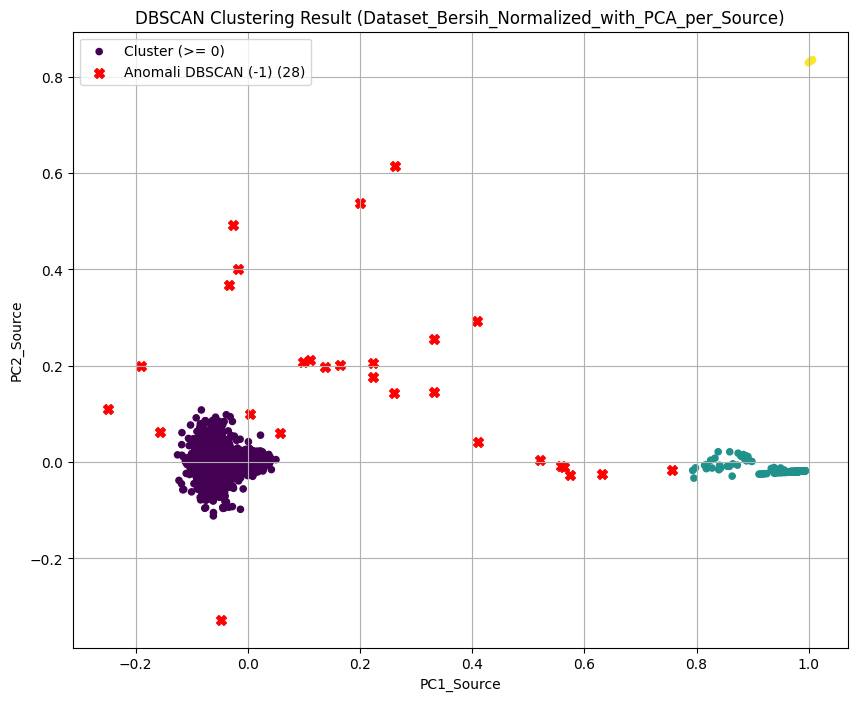


--- Selesai proses untuk Dataset_Bersih_Normalized_with_PCA_per_Source ---


In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN
import io
import os
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D # Tidak diperlukan lagi untuk plot 2D PCA
import seaborn as sns # Untuk pewarnaan plot yang lebih baik
import numpy as np # Tambahkan import numpy untuk operasi array
from sklearn.neighbors import NearestNeighbors # Import untuk k-distance graph
from scipy.stats import zscore # Import untuk perhitungan Z-score
from sklearn.ensemble import IsolationForest # Import Isolation Forest
# import matplotlib.colors as mcolors # Import for colors - Biasanya sudah tercakup

# Import files from google.colab
try:
    from google.colab import files
    print("Berjalan di lingkungan Colab. Gunakan files.upload() untuk mengunggah file.")
except ImportError:
    print("Warning: Tidak berjalan di lingkungan Colab. 'files.upload()' tidak akan berfungsi.")
    # Define dummy functions if not in Colab for code structure compatibility
    class DummyFiles:
        def upload(self):
            print("Dummy upload called. This function is for Google Colab.")
            return {} # Return empty dict as no files are uploaded
        def download(self, path):
            print(f"Dummy download called for {path}. This function is for Google Colab.")
    files = DummyFiles()

# --- Fungsi untuk membuat K-distance graph ---
def plot_k_distance(data, k, title):
    """
    Menghitung dan memplot jarak ke tetangga terdekat ke-k (k-distance graph).
    Membantu dalam memilih nilai eps untuk DBSCAN.
    """
    if data.empty:
        print(f"Tidak cukup data ({len(data)}) untuk membuat K-distance graph untuk: {title}")
        return

    # Pastikan k lebih kecil dari jumlah total sampel.
    # n_neighbors dalam sklearn termasuk titik itu sendiri.
    # Jika k adalah min_samples untuk DBSCAN, kita biasanya memplot jarak ke tetangga ke-min_samples (index min_samples-1).
    # Jadi, n_neighbors harus min_samples, dan kita ambil distances[:, min_samples-1].
    if k > len(data): # n_neighbors in NearestNeighbors must be <= n_samples
         print(f"Tidak cukup sampel ({len(data)}) untuk membuat K-distance graph dengan k={k} untuk: {title}")
         # Fallback to maximum possible neighbors if k is too large but data is not empty
         k = len(data)

    # Gunakan n_neighbors = k (dimana k adalah min_samples untuk DBSCAN)
    # Kita ambil jarak ke titik k-th termasuk diri sendiri, yaitu index k-1
    # Pastikan k >= 1
    k_actual = max(1, k)
    neigh = NearestNeighbors(n_neighbors=k_actual, algorithm='auto')
    neigh.fit(data)

    # Temukan jarak ke k tetangga terdekat
    distances, indices = neigh.kneighbors(data)

    # Ambil jarak ke k-th nearest neighbor (index k-1)
    if distances.shape[1] >= k: # Gunakan >= k karena index k-1 valid jika shape[1] == k
        k_distances = np.sort(distances[:, k - 1], axis=0)
    else:
        print(f"Could not compute {k}-th nearest neighbor distance for {title}. Check data or k value.")
        # Fallback if k=1 but distances.shape[1] is 0 (e.g., empty data, though checked above)
        if k == 1 and distances.shape[1] > 0:
             k_distances = np.sort(distances[:, 0], axis=0) # If k=1, distance to 1st neighbor (itself) is 0, this case unlikely needed if data not empty.
        else:
             print(f"Not enough neighbors found for k={k}. Skipping K-distance plot for {title}.")
             return


    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(k_distances)), k_distances) # Gunakan np.arange untuk sumbu x
    plt.xlabel(f'Points sorted by distance to {k}-th nearest neighbor')
    plt.ylabel(f'Distance to {k}-th nearest neighbor')
    plt.title(f'K-Distance Graph ({title})')
    plt.grid(True)
    plt.show()
# --------------------------------------------

# --- Fungsi untuk memplot hasil clustering 2D ---
def plot_2d_clustering(df, x_col, y_col, label_col, title):
    """
    Membuat plot 2D hasil clustering DBSCAN dengan highlight anomali.
    """
    if df.empty:
        print(f"Tidak ada data untuk diplot: {title}")
        return
    if not all(col in df.columns for col in [x_col, y_col, label_col]):
        print(f"Kolom yang dibutuhkan untuk plotting clustering 2D tidak lengkap di DataFrame untuk: {title}")
        print(f"Kolom yang tersedia: {df.columns.tolist()}")
        return

    plt.figure(figsize=(10, 8))
    ax = plt.gca() # Get current axes

    # Pisahkan data berdasarkan label cluster (-1 untuk anomali)
    anomalies = df[df[label_col] == -1]
    clustered = df[df[label_col] != -1]

    # Plot data yang terklaster (non-anomali)
    if not clustered.empty:
         unique_cluster_labels = sorted(clustered[label_col].unique())
         # Ensure colormap has enough colors
         cmap = plt.cm.get_cmap('viridis', max(len(unique_cluster_labels), 2))
         colors = [cmap(i) for i in range(len(unique_cluster_labels))]
         label_to_color = dict(zip(unique_cluster_labels, colors))
         # Map labels to colors
         # Pastikan semua label di clustered.index memiliki mapping di label_to_color
         c_values = [label_to_color.get(label, 'gray') for label in clustered[label_col]] # Use .get with a default color in case a label is missing

         ax.scatter(
             clustered[x_col],
             clustered[y_col],
             c=c_values, # Warna berdasarkan label cluster > -1
             s=20, # Ukuran marker
             label='Cluster (>= 0)' # Label untuk legend
         )

    # Plot data anomali (-1) dengan warna khusus (misal: merah)
    if not anomalies.empty:
         ax.scatter(
             anomalies[x_col],
             anomalies[y_col],
             c='red', # Warna merah untuk anomali
             s=50, # Ukuran marker lebih besar untuk anomali
             marker='X', # Bentuk marker silang untuk anomali
             label=f'Anomali DBSCAN (-1) ({len(anomalies)})' # Label untuk legend
         )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.show()
# --------------------------------------------


# --- Parameter Global ---
# Menggunakan nama kolom sesuai dengan hasil PCA di file Excel Anda
kolom_for_dbscan = ['PC1_Source', 'PC2_Source']
kolom_source = 'Source' # Kolom 'Source' untuk analisis
# minPts untuk DBSCAN (digunakan juga untuk K-Distance graph)
# Untuk data 2D, min_samples = 4 adalah nilai umum, tapi 5 juga bisa dicoba.
min_samples_value = 5 # Anda bisa mencoba nilai lain seperti 4 atau 6

# Parameter untuk anomali diperkaya (Z-score dan Isolation Forest)
zscore_threshold = 3 # Sesuaikan threshold jika perlu
isolation_forest_contamination = 'auto' # Atau bisa float antara 0 dan 0.5


print("Silakan unggah file Excel 'Dataset_Bersih_Normalized_with_PCA_per_Source (1).xlsx'.")
print("PENTING: Pastikan nama file yang Anda unggah persis atau mengandung 'Dataset_Bersih_Normalized_with_PCA_per_Source' (case-insensitive) dan berekstensi .xls atau .xlsx.")

# Upload file Excel
uploaded = files.upload()

# --- Proses Dataset Bersih Normalized PCA ---

print("\n--- Mulai proses DBSCAN dan Anomaly Detection untuk file Dataset_Bersih_Normalized_with_PCA_per_Source ---")
df_pca_bersih = None # Menggunakan nama variabel yang sesuai dengan dataset bersih
file_name = None

# Cari nama file yang diunggah yang mengandung 'Dataset_Bersih_Normalized_with_PCA_per_Source' (case-insensitive)
for name in uploaded.keys():
    if 'dataset_bersih_normalized_with_pca_per_source' in name.lower() and (name.lower().endswith('.xls') or name.lower().endswith('.xlsx')):
        file_name = name
        break

if file_name is not None:
    print(f"Memproses file: {file_name}")
    try:
        # Baca data dari file Excel menggunakan pandas dari byte string
        df_pca_bersih = pd.read_excel(io.BytesIO(uploaded[file_name]))

        print("DataFrame Dataset_Bersih_Normalized_with_PCA_per_Source (beberapa baris pertama):")
        print(df_pca_bersih.head())
        print("\nKolom di DataFrame Dataset_Bersih_Normalized_with_PCA_per_Source:")
        print(df_pca_bersih.columns.tolist())

        # Validasi kolom yang dibutuhkan ada setelah membaca
        # Akan lebih aman jika kita membersihkan nama kolom dari spasi di awal/akhir jika perlu,
        # tapi saat ini kita mengikuti nama kolom persis seperti di file Excel.
        # Jika nanti ada masalah spasi, kita bisa tambahkan:
        # df_pca_bersih.columns = df_pca_bersih.columns.str.strip()

        required_cols = kolom_for_dbscan + [kolom_source]
        if all(col in df_pca_bersih.columns for col in required_cols):
            X_pca_bersih = df_pca_bersih[kolom_for_dbscan].copy() # Gunakan .copy() untuk menghindari SettingWithCopyWarning

            # Hapus baris dengan nilai NaN jika ada di kolom yang dipilih
            original_rows = len(X_pca_bersih)
            # Penting: dropna di sini hanya berdasarkan kolom yang digunakan untuk deteksi anomali (kolom_for_dbscan)
            # Jika Anda ingin menghapus baris dengan NaN di kolom 'Source' juga, tambahkan kolom_source ke subset
            X_pca_bersih_cleaned = df_pca_bersih[kolom_for_dbscan].dropna().copy()
            # Kita perlu menyimpan indeks dari baris yang dihapus agar bisa filtering di df_pca_bersih
            dropped_indices = df_pca_bersih.index.difference(X_pca_bersih_cleaned.index)
            # Hapus baris yang sama dari df_pca_bersih
            df_pca_bersih_cleaned = df_pca_bersih.drop(dropped_indices).copy()


            dropped_rows = original_rows - len(X_pca_bersih_cleaned)
            if dropped_rows > 0:
                print(f"Peringatan: Menghapus {dropped_rows} baris dengan nilai NaN di kolom yang dipilih untuk deteksi anomali.")


            if not X_pca_bersih_cleaned.empty:
                # Sekarang gunakan df_pca_bersih_cleaned dan X_pca_bersih_cleaned
                X_pca_bersih = X_pca_bersih_cleaned
                df_pca_bersih = df_pca_bersih_cleaned
                pca_bersih_total = len(df_pca_bersih) # Update total data setelah dropna


                # --- Buat K-distance graph untuk menentukan eps ---
                print(f"\nMembuat K-distance graph untuk Dataset_Bersih_Normalized_with_PCA_per_Source (min_samples={min_samples_value})...")
                # plot_k_distance membutuhkan k=min_samples
                plot_k_distance(X_pca_bersih, min_samples_value, "Dataset_Bersih_Normalized_with_PCA_per_Source")
                print(f"Lihat grafik K-Distance di atas untuk membantu memilih nilai \'eps\'.")
                print(f"Gunakan nilai \'min_samples\' = {min_samples_value} untuk DBSCAN.")


                # --- Bagian untuk Menerapkan DBSCAN ---
                print("\nMenerapkan algoritma DBSCAN pada data PCA (Dataset_Bersih_Normalized_with_PCA_per_Source)...")
                # eps_pca_bersih = 0.09 # Nilai eps ini mungkin perlu disesuaikan berdasarkan K-Distance graph PCA
                # TODO: Sesuaikan nilai eps_pca_bersih berdasarkan K-Distance graph yang baru.
                # Contoh: Setelah melihat grafik, Anda mungkin menemukan 'siku' di jarak 0.05 atau 0.1.
                # Ganti 0.09 di bawah dengan nilai yang Anda pilih.
                eps_pca_bersih = 0.03 # Nilai eps awal, SILAKAN SESUAIKAN!
                print(f"Menggunakan eps={eps_pca_bersih} dan min_samples={min_samples_value} untuk DBSCAN.")
                dbscan_pca_bersih = DBSCAN(eps=eps_pca_bersih, min_samples=min_samples_value)
                df_pca_bersih['cluster_label_DBSCAN'] = dbscan_pca_bersih.fit_predict(X_pca_bersih)

                print("\nDataFrame Dataset_Bersih_Normalized_with_PCA_per_Source setelah penambahan label cluster DBSCAN (beberapa baris pertama):")
                print(df_pca_bersih.head())

                print("\nDistribusi jumlah data per cluster (Dataset_Bersih_Normalized_with_PCA_per_Source - DBSCAN):")
                pca_bersih_value_counts_dbscan = df_pca_bersih['cluster_label_DBSCAN'].value_counts()
                print(pca_bersih_value_counts_dbscan)
                pca_bersih_anomalies_dbscan = pca_bersih_value_counts_dbscan.get(-1, 0)
                pca_bersih_normal_dbscan = pca_bersih_total - pca_bersih_anomalies_dbscan
                print(f"\nTotal Data Dataset_Bersih_Normalized_with_PCA_per_Source: {pca_bersih_total}")
                print(f"Data Anomali/Noise Dataset_Bersih_Normalized_with_PCA_per_Source (DBSCAN -1): {pca_bersih_anomalies_dbscan}")
                print(f"Data Normal Dataset_Bersih_Normalized_with_PCA_per_Source (DBSCAN): {pca_bersih_normal_dbscan}")

                # Analisis Source untuk Anomali DBSCAN
                if pca_bersih_anomalies_dbscan > 0:
                    print("\nDistribusi Source untuk Anomali DBSCAN (-1):")
                    anomalies_dbscan_df = df_pca_bersih[df_pca_bersih['cluster_label_DBSCAN'] == -1]
                    print(anomalies_dbscan_df[kolom_source].value_counts())
                else:
                    print("\nTidak ada anomali yang terdeteksi oleh DBSCAN untuk dianalisis Sourcenya.")


                # --- Bagian untuk Menerapkan Z-score ---
                print("\nMenerapkan deteksi anomali menggunakan Z-score pada data PCA (Dataset_Bersih_Normalized_with_PCA_per_Source)...")
                # Z-score pada data PCA
                z_scores_pca = np.abs(zscore(X_pca_bersih))
                df_pca_bersih['is_anomaly_zscore'] = (z_scores_pca > zscore_threshold).any(axis=1).astype(int) # 1 untuk anomali, 0 untuk normal

                print("\nDataFrame Dataset_Bersih_Normalized_with_PCA_per_Source setelah penambahan label anomali Z-score (beberapa baris pertama):")
                print(df_pca_bersih.head())
                print(f"\nDistribusi jumlah data per label anomali Z-score (Dataset_Bersih_Normalized_with_PCA_per_Source - Z-score threshold={zscore_threshold}):")
                pca_bersih_value_counts_zscore = df_pca_bersih['is_anomaly_zscore'].value_counts()
                print(pca_bersih_value_counts_zscore)
                pca_bersih_anomalies_zscore = pca_bersih_value_counts_zscore.get(1, 0)
                pca_bersih_normal_zscore = pca_bersih_total - pca_bersih_anomalies_zscore
                print(f"\nData Anomali Dataset_Bersih_Normalized_with_PCA_per_Source (Z-score): {pca_bersih_anomalies_zscore}")
                print(f"Data Normal Dataset_Bersih_Normalized_with_PCA_per_Source (Z-score): {pca_bersih_normal_zscore}")

                # Analisis Source untuk Anomali Z-score
                if pca_bersih_anomalies_zscore > 0:
                    print("\nDistribusi Source untuk Anomali Z-score:")
                    anomalies_zscore_df = df_pca_bersih[df_pca_bersih['is_anomaly_zscore'] == 1]
                    print(anomalies_zscore_df[kolom_source].value_counts())
                else:
                    print("\nTidak ada anomali yang terdeteksi oleh Z-score untuk dianalisis Sourcenya.")


                # --- Bagian untuk Menerapkan Isolation Forest ---
                print("\nMenerapkan algoritma Isolation Forest pada data PCA (Dataset_Bersih_Normalized_with_PCA_per_Source)...")
                # Isolation Forest pada data PCA
                iso_forest_pca = IsolationForest(contamination=isolation_forest_contamination, random_state=42)
                df_pca_bersih['anomaly_label_isoforest'] = iso_forest_pca.fit_predict(X_pca_bersih)

                print("\nDataFrame Dataset_Bersih_Normalized_with_PCA_per_Source setelah penambahan label anomali Isolation Forest (beberapa baris pertama):")
                print(df_pca_bersih.head())
                print(f"\nDistribusi jumlah data per label anomali Isolation Forest (Dataset_Bersih_Normalized_with_PCA_per_Source - contamination={isolation_forest_contamination}):")
                pca_bersih_value_counts_isoforest = df_pca_bersih['anomaly_label_isoforest'].value_counts()
                print(pca_bersih_value_counts_isoforest)
                pca_bersih_anomalies_isoforest = pca_bersih_value_counts_isoforest.get(-1, 0)
                pca_bersih_normal_isoforest = pca_bersih_total - pca_bersih_anomalies_isoforest
                print(f"\nData Anomali Dataset_Bersih_Normalized_with_PCA_per_Source (Isolation Forest -1): {pca_bersih_anomalies_isoforest}")
                print(f"Data Normal Dataset_Bersih_Normalized_with_PCA_per_Source (Isolation Forest): {pca_bersih_normal_isoforest}")

                # Analisis Source untuk Anomali Isolation Forest
                if pca_bersih_anomalies_isoforest > 0:
                    print("\nDistribusi Source untuk Anomali Isolation Forest (-1):")
                    anomalies_isoforest_df = df_pca_bersih[df_pca_bersih['anomaly_label_isoforest'] == -1]
                    print(anomalies_isoforest_df[kolom_source].value_counts())
                else:
                     print("\nTidak ada anomali yang terdeteksi oleh Isolation Forest untuk dianalisis Sourcenya.")


                # --- Visualisasi DBSCAN Dataset_Bersih_Normalized_with_PCA_per_Source dengan Highlight Anomali DBSCAN ---
                print("\nMembuat visualisasi clustering DBSCAN untuk Dataset_Bersih_Normalized_with_PCA_per_Source dengan highlight anomali DBSCAN...")
                plot_2d_clustering(
                    df_pca_bersih,
                    kolom_for_dbscan[0], kolom_for_dbscan[1],
                    'cluster_label_DBSCAN',
                    'DBSCAN Clustering Result (Dataset_Bersih_Normalized_with_PCA_per_Source)'
                )

                # Anda bisa menambahkan visualisasi untuk hasil Z-score atau Isolation Forest
                # dengan memanggil plot_2d_clustering lagi menggunakan kolom label yang sesuai.
                # Contoh:
                # print("\nMembuat visualisasi anomali Z-score untuk Dataset_Bersih_Normalized_with_PCA_per_Source...")
                # plot_2d_clustering(
                #     df_pca_bersih,
                #     kolom_for_dbscan[0], kolom_for_dbscan[1],
                #     'is_anomaly_zscore', # Menggunakan kolom label Z-score
                #     'Z-score Anomaly Detection Result (Dataset_Bersih_Normalized_with_PCA_per_Source)'
                # )
                # print("\nMembuat visualisasi anomali Isolation Forest untuk Dataset_Bersih_Normalized_with_PCA_per_Source...")
                # plot_2d_clustering(
                #     df_pca_bersih,
                #     kolom_for_dbscan[0], kolom_for_dbscan[1],
                #     'anomaly_label_isoforest', # Menggunakan kolom label Isolation Forest
                #     'Isolation Forest Anomaly Detection Result (Dataset_Bersih_Normalized_with_PCA_per_Source)'
                # )


            else:
                 print(f"Error: Setelah menghapus baris dengan NaN, tidak ada data yang tersisa di kolom {kolom_for_dbscan}.")

        else:
             print(f"Error: Kolom PCA ({kolom_for_dbscan}) atau kolom Source ({kolom_source}) tidak ditemukan di file {file_name}. Pastikan nama kolom di file Excel sudah benar dan sesuai.")
             print(f"Kolom yang tersedia: {df_pca_bersih.columns.tolist()}")


    except Exception as e:
        print(f"Terjadi error saat memproses file {file_name}: {e}")
        import traceback
        print(traceback.format_exc()) # Print lengkap traceback error
        print("Pastikan file yang diunggah adalah file Excel yang benar dan memiliki kolom yang dibutuhkan.")
else:
    print("File 'Dataset_Bersih_Normalized_with_PCA_per_Source (1).xlsx' tidak ditemukan di antara file yang diunggah.")
    print("Pastikan nama file yang Anda unggah mengandung kata 'Dataset_Bersih_Normalized_with_PCA_per_Source' dan berekstensi .xls atau .xlsx")


print("\n--- Selesai proses untuk Dataset_Bersih_Normalized_with_PCA_per_Source ---")